In [5]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline

### Генерация данных

In [12]:
a = scipy.stats.multivariate_normal.rvs(size=150, mean=[0, 3], cov=[[2, 1.5], [1.5, 2]])
print type(a)
b = scipy.stats.multivariate_normal.rvs(size=200, mean=[2.5, 0], cov=[[2, -0.5], [-0.5, 2]])
X_train = np.vstack([a, b])
y_train = np.hstack([np.zeros(len(a)), np.ones(len(b))])
print X_train.shape, y_train.shape

<type 'numpy.ndarray'>
(350L, 2L) (350L,)


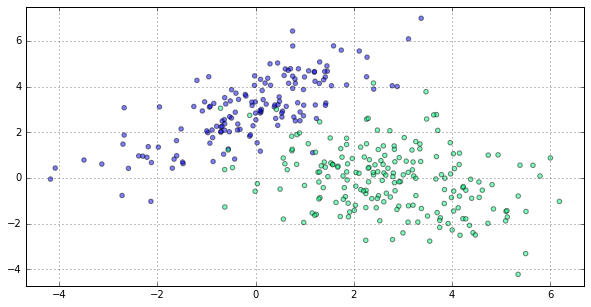

In [13]:
plt.figure(figsize=(10, 5))
plt.grid()
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, alpha=0.5, cmap='winter')
plt.xlim((min(X_train[:, 0]) - 0.5, max(X_train[:, 0]) + 0.5))
plt.ylim((min(X_train[:, 1]) - 0.5, max(X_train[:, 1]) + 0.5))
plt.show()

Данные для тестирования.

In [14]:
a = scipy.stats.multivariate_normal.rvs(size=2 * 150, mean=[0, 3], cov=[[2, 1.5], [1.5, 2]])
b = scipy.stats.multivariate_normal.rvs(size=2 * 200, mean=[2.5, 0], cov=[[2, -0.5], [-0.5, 2]])
X_test = np.vstack([a, b])
y_test = np.hstack([np.zeros(len(a)), np.ones(len(b))])
print X_test.shape, y_test.shape

(700L, 2L) (700L,)


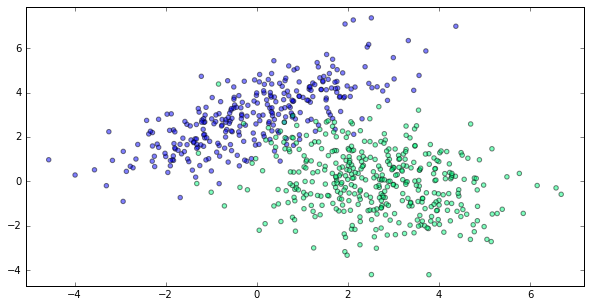

In [15]:
plt.figure(figsize=(10, 5))
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, alpha=0.5, cmap='winter')
plt.xlim((min(X_test[:, 0]) - 0.5, max(X_test[:, 0]) + 0.5))
plt.ylim((min(X_test[:, 1]) - 0.5, max(X_test[:, 1]) + 0.5))
plt.show()

### Модель

In [214]:
class ParzenWindowClassifier:
    x_train = np.ndarray(shape=(0,2))
    y_train = np.ndarray(shape=(0)) 
    
    def __init__(self, kernel, dist):
        self.dist = dist
        self.kernel = kernel
        
    def fit(self, x, y):
        self.x_train = np.vstack([self.x_train, x])
        self.y_train = np.hstack([self.y_train, y])
    
    def predict(self, x):
        res = np.empty(len(x))
        for i in range(len(x)):
            sum0 = sum1 = 0
            for j in range(len(self.x_train)):
                if (self.y_train[j] == 0):
                    sum0 += self.kernel(self.dist(x[i], self.x_train[j]))
                else:
                    sum1 += self.kernel(self.dist(x[i], self.x_train[j]))
            if sum0 > sum1:
                res[i] = 0
            else:
                res[i] = 1
        return res
    
    def predict_proba(self, x):
        res = np.empty(shape=(len(x), 2))
        for i in range(len(x)):
            sum0 = sum1 = 0
            for j in range(len(self.x_train)):
                if (self.y_train[j] == 0):
                    sum0 += self.kernel(self.dist(x[i], self.x_train[j]))
                else:
                    sum1 += self.kernel(self.dist(x[i], self.x_train[j]))
            res[i][0] = sum0 / (sum0 + sum1)
            res[i][1] = sum1 / (sum0 + sum1)
        return res

In [215]:
def uniform_kernel(x):
    return 0.5 * (abs(x) <= 1)

In [216]:
def gaussian_kernel(x):
    return np.exp(-x**2 / 2) / np.sqrt(2 * np.pi)

In [217]:
def dist(x, y):
    return np.sqrt((x[0] - y[0])**2 + (x[1] - y[1])**2)

### Обучение модели

In [218]:
model = ParzenWindowClassifier(gaussian_kernel, dist)
model.fit(X_train, y_train)

In [219]:
from sklearn.metrics import zero_one_loss
from sklearn.metrics import accuracy_score

Ошибка на обучении и на тесте

In [190]:
print zero_one_loss(y_train, model.predict(X_train))
print zero_one_loss(y_test, model.predict(X_test))

0.0342857142857
0.0485714285714


Качество на тесте

In [227]:
accuracy_score(y_test, model.predict(X_test))

0.9514285714285714

### Визуализация

In [192]:
def generate_grid(train_sample, border=1, step=0.05):
    return np.meshgrid(np.arange(min(train_sample[:, 0]) - border, max(train_sample[:, 1]) + border, step), 
                       np.arange(min(train_sample[:, 1]) - border, max(train_sample[:, 1]) + border, step))

In [240]:
def create_picture(X_train, y_train, model, border=1, step=0.1, figsize=(18, 5), cmap='winter', alpha=1):
    
    model.fit(X_train, y_train)
    # Создание сетки
    grid = generate_grid(X_train, border, step)
    grid_ravel = np.c_[grid[0].ravel(), grid[1].ravel(0)]  # Выворачивание сетки
    
    # Предсказание значений для сетки
    grid_predicted_ravel = model.predict_proba(grid_ravel)[:, 1]  # Берем вероятности для первого класса
    grid_predicted = grid_predicted_ravel.reshape(grid[0].shape)  # Подгоняем размер
    
    
    # Построение фигуры
    plt.figure(figsize=figsize)
    
    plt.subplot(1, 2, 1)
    plt.pcolormesh(grid[0], grid[1], grid_predicted > 0.5, cmap=cmap)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, alpha=alpha, cmap=cmap)
    plt.xlim((min(grid_ravel[:, 0]), max(grid_ravel[:, 0])))
    plt.ylim((min(grid_ravel[:, 1]), max(grid_ravel[:, 1])))
    #plt.title(u'Классификация {}-NN'.format(model.get_params()['n_neighbors']))
    
    plt.subplot(1, 2, 2)
    plt.pcolormesh(grid[0], grid[1], grid_predicted, cmap=cmap)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, alpha=alpha, cmap=cmap)
    plt.xlim((min(grid_ravel[:, 0]), max(grid_ravel[:, 0])))
    plt.ylim((min(grid_ravel[:, 1]), max(grid_ravel[:, 1])))
    #plt.title(u'Вероятности {}-NN'.format(model.get_params()['n_neighbors']))
    
    plt.show()
    
    
    # Удаление лишних данных
    del(grid)
    del(grid_ravel)
    del(grid_predicted_ravel)
    del(grid_predicted)

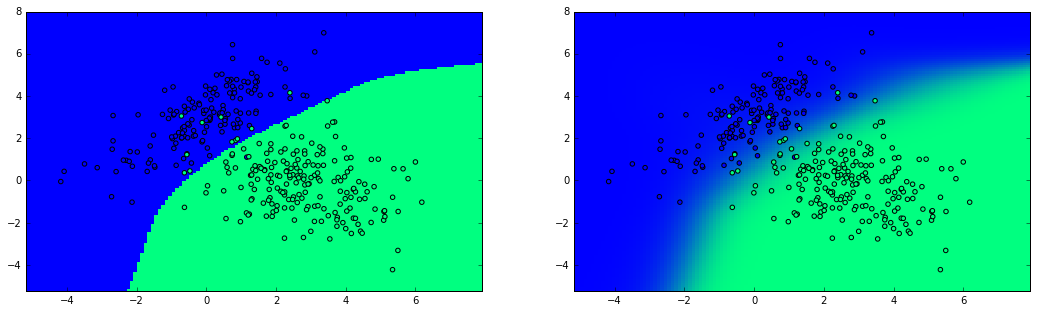

In [241]:
#for n_neighbors in [1, 3, 10, 50]:
create_picture(X_train, y_train, ParzenWindowClassifier(gaussian_kernel, dist))